# Imports

In [7]:
# librairies communes
from os import listdir
import os
import pickle
import math
import random

import pandas as pd
import numpy as np 

#Graph
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
from sklearn.cluster import KMeans

# Computer vision
import time, cv2

# Librairies tensorflow
import tensorflow as tf

# Librairies Keras 
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, UpSampling2D, Dropout, Dense, Flatten
from keras.callbacks import TensorBoard
from keras.utils.np_utils import to_categorical
from keras.utils import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input, VGG16
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [8]:
from PIL import UnidentifiedImageError

In [9]:
from keras.preprocessing import image

In [10]:
import ipywidgets as widgets
from ipywidgets import interact, fixed

In [11]:
tf.config.run_functions_eagerly(True)

# 1. Chargement des données

In [12]:
CLEAN_DATA_PATH = 'data/clean_data/'
DATA_PATH = 'data/'
PHOTOS_PATH = CLEAN_DATA_PATH + 'photos/'

In [13]:
photos = pd.read_json(DATA_PATH + 'photos.json', lines=True)

Filtrage des photos du dataframe qui sont bien dans les données de photos.

In [14]:
photos = photos[photos.apply(lambda x: os.path.exists(PHOTOS_PATH + x.photo_id + '.jpg'), axis=1)]

On rajoute l'extension au noms des photos dans le dataframe. Cela simplifiera les appels aux données des photos.

In [15]:
photos['photo_id'] = photos['photo_id'].apply(lambda x: x + '.jpg')

In [16]:
photos.head()

,photo_id,business_id,caption,label
0,zsvj7vloL4L5jhYyPIuVwg.jpg,Nk-SJhPlDBkAZvfsADtccA,Nice rock artwork everywhere and craploads of ...,inside
1,HCUdRJHHm_e0OCTlZetGLg.jpg,yVZtL5MmrpiivyCIrVkGgA,,outside
2,vkr8T0scuJmGVvN2HJelEA.jpg,_ab50qdWOk0DdB6XOrBitw,oyster shooter,drink
3,pve7D6NUrafHW3EAORubyw.jpg,SZU9c8V2GuREDN5KgyHFJw,Shrimp scampi,food
4,H52Er-uBg6rNrHcReWTD2w.jpg,Gzur0f0XMkrVxIwYJvOt2g,,food


Deux colonnes nous intéressent, photo_id et label

In [17]:
photos = photos[['photo_id', 'label']]

#### Erreur sur certaines images

In [18]:
def detect_missing_photo(df):
    missing_photos = []
    for photo in df['photo_id']:
        if not os.path.exists(PHOTOS_PATH + photo):
            missing_photos.append(photo)
    return missing_photos

In [19]:
def detect_empty_photo(df):
    errors = []
    for photo in df['photo_id']:
        image = cv2.imread(PHOTOS_PATH + photo, 0)
        if image is None:
            errors.append(photo)
    return errors

In [20]:
detect_missing_photo(photos)

[]

In [22]:
errors = ['MduVueqYTBlEkX-axrh1ug.jpg', 'l2vR3PyVMF3pgIERdDEuiQ.jpg', '1wd_eyhMrTqUmicDmn4_Kw.jpg', 'K6pfRNwGodm1m1gFVQlj-Q.jpg', 'ARwqGQZaT0p-XpYYjMXgQg.jpg', '5q-sAvIPl0yNeuAbNBPM1g.jpg',
 'ytJ4lihJrvyzMMRG-WwDNw.jpg', '6bKuH4FOdaaPInF9NmlQHQ.jpg', 'PjfJoBrEFgDrxiJy8nyatA.jpg']

In [23]:
for error in errors:
    print(os.path.exists(PHOTOS_PATH + error))

True
True
True
True
True
True
True
True
True


In [24]:
for error in errors:
    photos = photos[photos['photo_id'] != error]

# 2. Exploration

In [25]:
photos.shape

(200091, 2)

## 2.1. Labels

On stocke les alternatives pour nos labels.

In [26]:
labels_choice = list(photos['label'].unique())

<AxesSubplot:ylabel='label'>

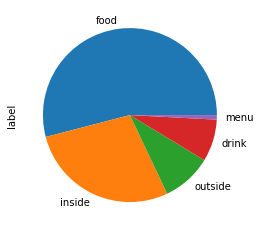

In [27]:
photos.label.value_counts().plot.pie()

Leur distribution est inégale, avec une très grande majorité de nourriture ou de photo extérieur et très peu de menus.

On a plus de 200 000 photos, leur traitement peuvent être long on va donc constituer des échantillons.  
On peut par la même occasion équilibrer ses échantillons pour un meilleur apprentissage par la suite.

In [28]:
sample_nb = min(photos.label.value_counts())

Si on souhaite un équilibre parfait, on peut utiliser la classe la moins représenté comme base.  
En effet les menus sont au nombre de 1 678, on peut donc prendre 1 678 photos de chaque labels pour avoir un équilibre. 

## 2.2. Photos

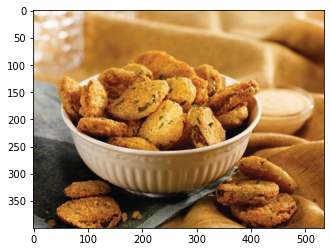

In [29]:
filename = PHOTOS_PATH + photos['photo_id'].sample(ignore_index=True)[0]
image = imread(filename)
plt.imshow(image)

Affichage aléatoire de 3 photos de chaque catégorie

inside
------------------------------


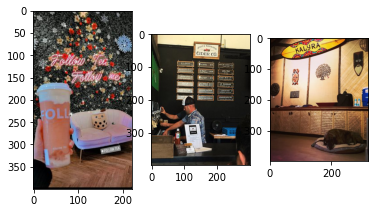

outside
------------------------------


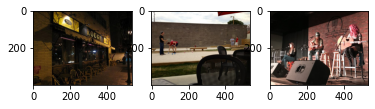

drink
------------------------------


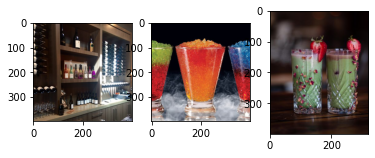

food
------------------------------


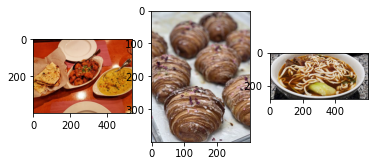

menu
------------------------------


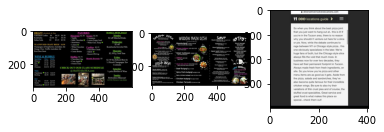

In [30]:
for label in labels_choice :
    print(label)
    print(30*"-")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = PHOTOS_PATH + photos[photos.label == label].sample()['photo_id'].values[0]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

# Sélection des données

In [31]:
SAMPLE_SIZE       = 2000

IMGSIZE           = (224, 224)    # Taille de l'image en input
IMGSIZECOLOR      = (224, 224, 3) 

In [32]:
balanced_df_max = pd.DataFrame()
for label in labels_choice:
    balanced_df_max = pd.concat([balanced_df_max, photos[photos.label==label].sample(sample_nb, random_state=1)])

In [33]:
balanced_df_max = balanced_df_max.reset_index(drop=True)

In [34]:
balanced_df_max.sample(5)

,photo_id,label
1660,_xhz-UbndQGHBRnE1KcgMg.jpg,inside
4205,7U7o_n0KTTHsSaoY_Y2CfA.jpg,drink
5725,VPlDxA6UzCubHuIXiMhKlg.jpg,food
243,bdNJSshgQFYqMDh1uEOZ2w.jpg,inside
6533,oDwrEY7dorNP8LqnhmNaAQ.jpg,food


### Vérifications

In [35]:
detect_empty_photo(balanced_df_max)

[]

**Equilibre des labels**

In [36]:
balanced_df_max.label.value_counts()

inside     1678
outside    1678
drink      1678
food       1678
menu       1678
Name: label, dtype: int64

<AxesSubplot:ylabel='label'>

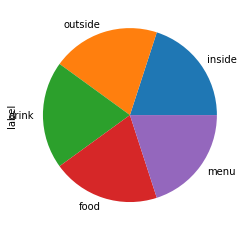

In [37]:
balanced_df_max.label.value_counts().plot.pie()

**Existance de la photo**

In [38]:
for photo in balanced_df_max.photo_id:
    filename = PHOTOS_PATH + photo
    if not os.path.exists(filename):
        print('1')

In [39]:
TEST_SIZE = 0.2
VAL_SIZE = 0.2

**Images problématiques**

In [40]:
# image = 'MduVueqYTBlEkX-axrh1ug.jpg'

In [41]:
# os.path.exists(PHOTOS_PATH + image)

In [42]:
# img_to_array(load_img(path,target_size=(224,224)))

In [43]:
# image = imread(PHOTOS_PATH + image)
# plt.imshow(image)

In [44]:
def balanced_sample_df(df, labels, size, random_state=None):
    new_df = pd.DataFrame()
    for label in labels:
        new_df = pd.concat([new_df, df[df.label==label].sample(size//len(labels), random_state=random_state)])
    return new_df.reset_index(drop=True)

In [45]:
def preprocess_img(photo, image_path, target_size):
    try: 
        image = img_to_array(load_img(image_path + photo, target_size=target_size))
    except UnidentifiedImageError as e:
        print(photo)
        print(e)
    return image

In [46]:
# preprocess_img(balanced_df['photo_id'][0], image_path=PHOTOS_PATH, target_size=IMGSIZE)

In [47]:
def preprocess_images(photo_series, image_path, target_size):
    img_list = [preprocess_img(photo, image_path=image_path, target_size=target_size) for photo in photo_series]
    photo_array = np.asarray(img_list)
    return photo_array

In [48]:
def preprocess_one_image(photo, image_path, target_size):
    img = tf.keras.utils.img_to_array(load_img(image_path + photo, target_size=target_size))
    photo_array = np.asarray(img)
    return photo_array

In [49]:
def preprocess_labels(labels):
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(labels)
    y_train_ohe = tf.keras.utils.to_categorical(y_train_encoded)
    return y_train_ohe

In [50]:
def pipeline(df, data_columns, labels_column, sample_size, labels, image_path, target_size, test_size=0.2, val_size=0.2, random_state=None):
    balanced_df = balanced_sample_df(df=df, labels=labels, size=sample_size, random_state=random_state)
    
    X = balanced_df[data_columns]
    y = balanced_df[labels_column]
    
    X_train, X_test, y_train, y_test = train_test_split(X,       y,       test_size=test_size, stratify=y,       random_state=random_state)
    X_train, X_val, y_train, y_val   = train_test_split(X_train, y_train, test_size=test_size, stratify=y_train, random_state=random_state)

    X_train = preprocess_images(X_train, image_path=image_path, target_size=target_size)
    X_test  = preprocess_images(X_test,  image_path=image_path, target_size=target_size)
    X_val   = preprocess_images(X_val,   image_path=image_path, target_size=target_size)

    y_train = preprocess_labels(y_train)
    y_test  = preprocess_labels(y_test)
    y_val   = preprocess_labels(y_val)
    
    return X_train, X_test, X_val, y_train, y_test, y_val

In [52]:
X_train, X_test, X_val, y_train, y_test, y_val = pipeline(balanced_df_max, 'photo_id', 'label', sample_size=SAMPLE_SIZE, labels=labels_choice, image_path=PHOTOS_PATH, target_size=IMGSIZE,test_size=TEST_SIZE, val_size=TEST_SIZE, random_state=0)

#### Vérifications

In [53]:
detect_missing_photo(balanced_df_max)

[]

In [54]:
print(f"Taille du jeu d'entrainement : {X_train.shape[0]}")
print(f"Taille du jeu de test : {X_test.shape[0]}")
print(f"Taille du jeu de validation : {X_val.shape[0]}")

Taille du jeu d'entrainement : 1280
Taille du jeu de test : 400
Taille du jeu de validation : 320


Equilibre des labels

In [55]:
y_train.sum(axis=0)

array([256., 256., 256., 256., 256.], dtype=float32)

In [56]:
y_test.sum(axis=0)

array([80., 80., 80., 80., 80.], dtype=float32)

In [57]:
y_val.sum(axis=0)

array([64., 64., 64., 64., 64.], dtype=float32)

# Modélisation

# 3. Clustering des images via SIFT

## 3.1. Traitement pour une image

In [58]:
sift = cv2.xfeatures2d.SIFT_create()
image = cv2.imread(PHOTOS_PATH + balanced_df_max.sample()['photo_id'].values[0], 0) # convert in gray
image = cv2.equalizeHist(image)   # equalize image histogram

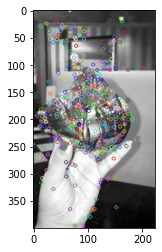

In [59]:
kp, des = sift.detectAndCompute(image, None)
img = cv2.drawKeypoints(image, kp, image)
plt.imshow(img)
plt.show()

## 3.2. Généralisation sur toutes les images
Pour chaque image :

* passage en gris et égalisation
* création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
* création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs

In [60]:
%%time

sift_keypoints = []
sift = cv2.xfeatures2d.SIFT_create(500)

for photo in balanced_df_max.photo_id:
    image = cv2.imread(PHOTOS_PATH + photo, 0)
    # image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    image_equalized = cv2.equalizeHist(image)   # equalize image histogram
    if image is None:
        print(photo)
    kp, des = sift.detectAndCompute(image_equalized, None)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints, dtype=object)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

Nombre de features :  4073169
CPU times: total: 15min 58s
Wall time: 3min 53s


In [61]:
print("Nombre de features : ", len(sift_keypoints_all))

Nombre de features :  4073169


## 3.3. Création des clusters de descripteurs

On uilise MiniBatchKMeans pour obtenir des temps de traitement raisonnables.  

Le choix du nombre de cluster se base sur le nombre de descripteur que nous avons obtenus.  
On prend la racine carrée du nombre de descripteur.  

In [62]:
k = int(round(np.sqrt(len(sift_keypoints_all)), 0))
print("Nombre de clusters estimés : ", k)

Nombre de clusters estimés :  2018


In [63]:
%%time
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0, batch_size=4096)
kmeans.fit(sift_keypoints_all)

CPU times: total: 9min 56s
Wall time: 55.7 s


MiniBatchKMeans(batch_size=4096, init_size=6054, n_clusters=2018,
                random_state=0)

Le temps de calcul est autour de 1 minute.

## 3.4. Création des features des images

Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme où  on compte pour chaque numéro de cluster, le nombre de descripteurs de l'image

In [64]:
%%time
def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    #if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

CPU times: total: 2h 17min 35s
Wall time: 12min 31s


Temps de calcul de 5-6 minutes

## 3.5. Réductions de dimension

### 3.5.1. ACP

La réduction de dimension à l'aide d'une ACP permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (95%).  
Cela permet une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [65]:
print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.95)
feat_pca = pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (8390, 2018)
Dimensions dataset après réduction PCA :  (8390, 1522)


### 3.5.2. T-SNE
Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [66]:
tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = balanced_df_max["label"]
print(df_tsne.shape)


C:\Users\solmy\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(8390, 3)


In [67]:
df_tsne.head()

,tsne1,tsne2,class
0,-48.037907,-15.402214,inside
1,5.057868,10.939997,inside
2,-13.519821,39.263813,inside
3,-0.761308,0.607296,inside
4,-7.552163,-41.927807,inside


In [68]:
df_tsne.shape

(8390, 3)

### 3.5.3. T-SNE avec les labels

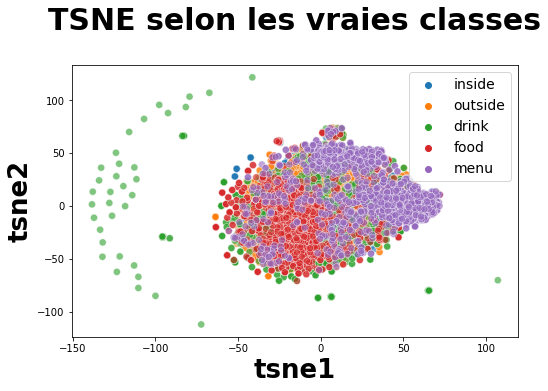

In [69]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

Le graphique peut être compliqué à lire, construisons également un graphique par classe.

In [70]:
colors = {
    'inside' : sns.color_palette('tab10', n_colors=5)[0],
    'outside' : sns.color_palette('tab10', n_colors=5)[1],
    'drink' : sns.color_palette('tab10', n_colors=5)[2],
    'food' : sns.color_palette('tab10', n_colors=5)[3],
    'menu' : sns.color_palette('tab10', n_colors=5)[4],
}


In [71]:
labels_elements = {
    'Intérieur': 'inside',
    'Extérieur': 'outside',
    'Menu': 'menu',
    'Nourriture': 'food',
    'Boisson': 'drink',
}
@interact(element=labels_elements)
def choix_element(element):
    sns.scatterplot(x="tsne1", y="tsne2", data=df_tsne[df_tsne["class"]==element], color=colors[element], s=50, alpha=0.6)

    plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
    plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
    plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
    plt.legend(prop={'size': 14}) 

    plt.show()

interactive(children=(Dropdown(description='element', options={'Intérieur': 'inside', 'Extérieur': 'outside', …

On peut distinguer :
- les menus vers la droite
- les boissons vers le milieu
- la nourriture plutôt vers le bas gauche

L'extérieur et l'intérieur sont très dispersés.

## 3.6. Clustering sur les variables du T-SNE

### 3.6.1. Modélisation

In [72]:
cls = cluster.KMeans(n_clusters=5, random_state=4)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(8390, 4)


In [73]:
df_tsne.cluster.value_counts()

3    2042
4    2022
2    1693
0    1378
1    1255
Name: cluster, dtype: int64

###  3.6.2. Affichage des images selon clusters 

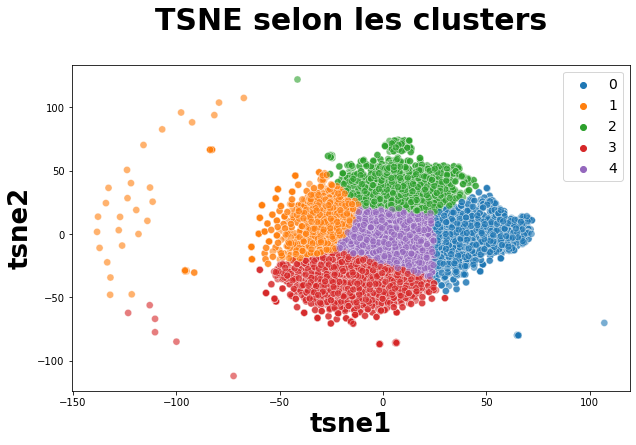

In [74]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

### 3.6.3. Evaluation

In [75]:
print("ARI : ", metrics.adjusted_rand_score(df_tsne["class"], df_tsne["cluster"]))

ARI :  0.11171210174387003


Le score ARI de 0.11 très faible, ce qui est cohérent avec la difficulté à visualiser des clusters avec les vraies classes.

In [76]:
label_encoder = LabelEncoder()
y_true = label_encoder.fit_transform(df_tsne["class"])

In [77]:
conf_mat_1 = metrics.confusion_matrix(y_true, df_tsne["cluster"])
print(conf_mat_1)

[[156 240 147 810 325]
 [ 68 432  78 667 433]
 [103 230 514 203 628]
 [891  64 534  74 115]
 [160 289 420 288 521]]


La matrice de confusion doit être transformée pour mettre avoir en colonne le même ordre des catégories supposées qu'en ligne

In [78]:
for k in range(5):
    print(f'cluster {k}')
    print(df_tsne[df_tsne["cluster"] == k]["class"].value_counts())
    print()

cluster 0
menu       891
outside    160
drink      156
inside     103
food        68
Name: class, dtype: int64

cluster 1
food       432
outside    289
drink      240
inside     230
menu        64
Name: class, dtype: int64

cluster 2
menu       534
inside     514
outside    420
drink      147
food        78
Name: class, dtype: int64

cluster 3
drink      810
food       667
outside    288
inside     203
menu        74
Name: class, dtype: int64

cluster 4
inside     628
outside    521
food       433
drink      325
menu       115
Name: class, dtype: int64



On voit nettement que :
 - le cluster 0 correspond aux menus
 - le cluster 1 correspond à la nourriture
 - le cluster 3 correspond aux boissons
 
La distinction entre extérieur et intérieur est très ténue, on supposera que :
 - le cluster 4 correspond à l'intérieur
 - le cluster 2 correspond à l'extérieur

On peut le confirmer avec :

In [79]:
label_matches = np.argmax(conf_mat_1, axis=0)
label_matches

array([3, 1, 3, 0, 2], dtype=int64)

En cas de trop mauvaises prédictions, les correspondances peuvent ne pas fonctionner. Auquel cas il faut départager.  
Ici les cluster 0 et 2 sont attibués aux menus et l'extérieur n'est pas attribué. On réattribue le 2 à l'extérieur

In [80]:
for k in range(0,5):
    if k not in label_matches:
        print('matching error :', k)

matching error : 4


In [81]:
def conf_mat_transform(y_true, y_pred, matches=None) :
    # Première matrice désordonnée
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    if matches is None:
        # Calcul indice ayant les valeurs maximales
        matches = np.argmax(conf_mat, axis=0)

    print ("Correspondance des clusters : ", matches)
    
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : matches[x]) 
    
    return labels['y_pred_transform']

In [82]:
y_pred_transform = conf_mat_transform(y_true, df_tsne["cluster"], matches=[3, 1, 4, 0, 2])

Correspondance des clusters :  [3, 1, 4, 0, 2]


In [83]:
conf_mat = metrics.confusion_matrix(y_true, y_pred_transform)
conf_mat

array([[810, 240, 325, 156, 147],
       [667, 432, 433,  68,  78],
       [203, 230, 628, 103, 514],
       [ 74,  64, 115, 891, 534],
       [288, 289, 521, 160, 420]], dtype=int64)

In [84]:
print(metrics.classification_report(y_true, y_pred_transform))

              precision    recall  f1-score   support

           0       0.40      0.48      0.44      1678
           1       0.34      0.26      0.29      1678
           2       0.31      0.37      0.34      1678
           3       0.65      0.53      0.58      1678
           4       0.25      0.25      0.25      1678

    accuracy                           0.38      8390
   macro avg       0.39      0.38      0.38      8390
weighted avg       0.39      0.38      0.38      8390



In [85]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in label_encoder.classes_], columns = [i for i in label_matches])

<AxesSubplot:>

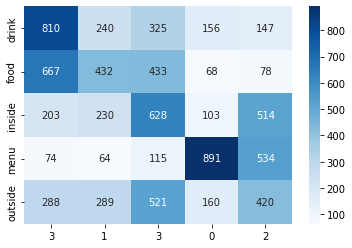

In [86]:
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='g')

On peut ainsi lire les confusions les plus répandues et les éléments bien identifiés.

**Menu**  

Sans surprise les menus apparaissent comme les plus identifiables. On voit néanmoins qu'il peut avoir des confusions avec le cluster 0 qui correspondrait à l'intérieur.  
On peut l'expliquer par le fait que les photos des menus sont parfois des prises d'un menu afficher à l'intérieur d'un restaurant.

**Boisson**

Elles sont assez bien identifiées, elles se confondent avec la nourriture mais assez peu avec les autres labels.

**Nourriture**

De même que les boissons, la nourriture est plutôt bien identifiée même si les confusions ne sont pas qu'avec la boisson mais aussi avec l'extérieur et l'intérieur.

**Intérieur et extérieur**

Difficile d'analyser ces deux éléments. Leur potentiel cluster sont assez similaires et confondent intérieur, extérieur et nourriture.

#### Export pour la page web

In [87]:
# with open("results/CV/sift_tsne", "wb") as fp:
#     pickle.dump(df_tsne, fp)

In [88]:
# with open("results/CV/sift_cm", "wb") as fp:
#     pickle.dump(df_cm, fp)

# 4. Transfer Learning par extraction de features

In [100]:
EPOCH          = 10            # nombre d'epoch 
FREEZE_LAYERS  = 15            # pour un VGG16 freeze de réapprentissage de certaines couches

## 4.1. Chargement d'un modèle VGG16 entrainé

In [101]:
base_model = VGG16(include_top=False, weights=None, input_tensor=None, input_shape=IMGSIZECOLOR)
base_model.load_weights('./trained_model/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5') 

In [102]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## 4.3. Extraction des features puis ACP et T-SNE

In [103]:
balanced_df = balanced_sample_df(photos, size=SAMPLE_SIZE, labels=labels_choice, random_state=0)

In [104]:
detect_empty_photo(balanced_df)

[]

In [105]:
balanced_df.label.value_counts()

inside     400
outside    400
drink      400
food       400
menu       400
Name: label, dtype: int64

### 4.3.1. Extraction de feature sur une photo

In [106]:
one_photo = preprocess_one_image(balanced_df.iloc[0].photo_id, PHOTOS_PATH, target_size=IMGSIZECOLOR)

In [107]:
features_one_photo = base_model.predict(np.asarray([one_photo]))

C:\Users\solmy\anaconda3\envs\MachineLearning\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 258ms/step


In [108]:
features_one_photo.shape

(1, 7, 7, 512)

In [109]:
features_flat = features_one_photo.flatten()

In [110]:
features_flat.shape

(25088,)

### 4.3.2. Généralisation

In [111]:
def extract_features(model, df, image_path, target_size):
    features_list = []

    for photo in df.photo_id:
        photo_preprocessed = preprocess_one_image(photo, image_path=image_path, target_size=target_size)
        photo_preprocessed_np = np.asarray([photo_preprocessed])

        features = model.predict(photo_preprocessed_np)
        features_np = np.array(features)
        features_list.append(features_np.flatten())
        
    return np.array(features_list)

In [ ]:
%%time
all_features = extract_features(base_model, balanced_df, PHOTOS_PATH, target_size=IMGSIZECOLOR)

In [113]:
all_features.shape

(2000, 25088)

### 4.3.3. ACP

In [114]:
print("Dimensions dataset avant réduction PCA : ", all_features.shape)
pca = decomposition.PCA(n_components=0.95)
feat_pca = pca.fit_transform(all_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (2000, 25088)
Dimensions dataset après réduction PCA :  (2000, 1464)


### 4.3.4. TSNE

In [115]:
tsne2 = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne2 = tsne2.fit_transform(feat_pca)

C:\Users\solmy\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [116]:
transfer_tsne = pd.DataFrame(X_tsne2[:,0:2], columns=['tsne1', 'tsne2'])
transfer_tsne["class"] = balanced_df["label"]
print(transfer_tsne.shape)

(2000, 3)


In [117]:
X_tsne2 = transfer_tsne[['tsne1', 'tsne2']].values

In [118]:
transfer_tsne['class'].value_counts()

inside     400
outside    400
drink      400
food       400
menu       400
Name: class, dtype: int64

#### T-SNE selon labels

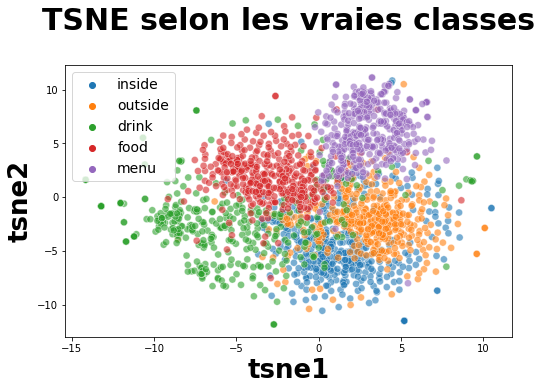

In [119]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=transfer_tsne, legend="brief", s=50, alpha=0.6,
    palette=sns.color_palette('tab10', n_colors=5))

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

Le graphique peut être compliqué à lire, construisons également un graphique par classe.

In [120]:
colors = {
    'inside' : sns.color_palette('tab10', n_colors=5)[0],
    'outside' : sns.color_palette('tab10', n_colors=5)[1],
    'drink' : sns.color_palette('tab10', n_colors=5)[2],
    'food' : sns.color_palette('tab10', n_colors=5)[3],
    'menu' : sns.color_palette('tab10', n_colors=5)[4],
}


In [121]:
labels_elements = {
    'Intérieur': 'inside',
    'Extérieur': 'outside',
    'Menu': 'menu',
    'Nourriture': 'food',
    'Boisson': 'drink',
}
@interact(element=labels_elements)
def choix_element(element):
    sns.scatterplot(x="tsne1", y="tsne2", data=transfer_tsne[transfer_tsne["class"]==element], color=colors[element], s=50, alpha=0.6)

    plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
    plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
    plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
    plt.legend(prop={'size': 14}) 

    plt.show()

interactive(children=(Dropdown(description='element', options={'Intérieur': 'inside', 'Extérieur': 'outside', …

On peut distinguer :
- les menus vers la droite
- les boissons plutôt centre droit
- la nourriture plutôt centre gauche


### 4.3.5. Clustering

In [122]:
cls = cluster.KMeans(n_clusters=5, random_state=6)
cls.fit(X_tsne2)

transfer_tsne["cluster"] = cls.labels_
print(transfer_tsne.shape)

C:\Users\solmy\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


(2000, 4)


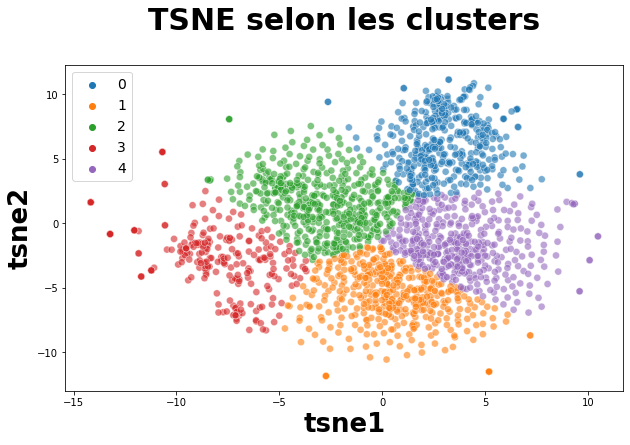

In [123]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=5), s=50, alpha=0.6,
    data=transfer_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

#### Evaluation

In [124]:
print("ARI : ", metrics.adjusted_rand_score(transfer_tsne["class"], transfer_tsne["cluster"]))

ARI :  0.5546889095995512


Un indice de Rand ajusté plus intéressant de plus de 0.5.

In [125]:
label_encoder = LabelEncoder()
y_true = label_encoder.fit_transform(transfer_tsne["class"])

In [ ]:
conf_mat = metrics.confusion_matrix(y_true, transfer_tsne["cluster"])

La matrice de confusion doit être transformée pour mettre avoir en colonne le même ordre des catégories supposées qu'en ligne

In [127]:
for k in range(5):
    print(f'cluster {k}')
    print(transfer_tsne[transfer_tsne["cluster"] == k]["class"].value_counts())
    print()

cluster 0
menu       374
food        15
drink       10
outside      9
inside       8
Name: class, dtype: int64

cluster 1
inside     286
outside     67
drink       63
food         6
menu         2
Name: class, dtype: int64

cluster 2
food       366
drink       61
inside      32
outside     21
menu        16
Name: class, dtype: int64

cluster 3
drink      245
food        10
outside      2
Name: class, dtype: int64

cluster 4
outside    301
inside      74
drink       21
menu         8
food         3
Name: class, dtype: int64



On voit que :
 - le cluster 0 correspond aux menus
 - le cluster 1 correspond à l'intérieur 
 - le cluster 2 correspond à la nourriture
 - le cluster 3 correspond aux boissons
 - le cluster 4 correspond à l'extérieur

On peut le confirmer avec :

In [128]:
label_matches = np.argmax(conf_mat, axis=0)
label_matches

array([3, 2, 1, 0, 4], dtype=int64)

In [129]:
y_pred_transform = conf_mat_transform(y_true, transfer_tsne["cluster"])

Correspondance des clusters :  [3 2 1 0 4]


In [130]:
print(metrics.classification_report(y_true, y_pred_transform))

              precision    recall  f1-score   support

           0       0.95      0.61      0.75       400
           1       0.74      0.92      0.82       400
           2       0.67      0.71      0.69       400
           3       0.90      0.94      0.92       400
           4       0.74      0.75      0.75       400

    accuracy                           0.79      2000
   macro avg       0.80      0.79      0.78      2000
weighted avg       0.80      0.79      0.78      2000



In [149]:
label_encoder.classes_

array(['drink', 'food', 'inside', 'menu', 'outside'], dtype=object)

In [131]:
[i for i in label_matches]

[3, 2, 1, 0, 4]

In [132]:
transfer_cm = pd.DataFrame(conf_mat, index=[label for label in label_encoder.classes_], columns=[i for i in label_matches])

In [133]:
transfer_cm = transfer_cm.reindex(sorted(transfer_cm.columns), axis=1)

<AxesSubplot:>

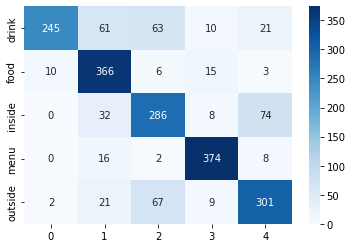

In [134]:
plt.figure(figsize = (6,4))
sns.heatmap(transfer_cm, annot=True, cmap="Blues", fmt='g')

Comme l'indice de Rand ajusté, la matrice de confusion est bien plus intéressante.

On voit que pour les boissons :
 - les images d'autres labels sont rarement prédites en boisson
 - les images sont parfois prédites comme extérieur, intérieur ou de nourriture  
 
Pour la nourriture :
 - les images de nourriture sont bien prédites globalement
 - seules les images de boissons sont régulièrement prédites comme de nourriture  
 
Pour l'intérieur, beaucoup de confusions surtout avec l'extérieur
Pour les menus, de très bonne prédictions, seule quelques prédictions de menu comme extérieur
Pour l'extérieur, beaucoup de confusions surtout avec l'intérieur.

In [140]:
with open("results/CV/transfer_tsne", "wb") as fp:
    pickle.dump(transfer_tsne, fp)

In [141]:
with open("results/CV/transfer_cm", "wb") as fp:
    pickle.dump(transfer_cm, fp)

# 5. Image Classification avec Transfer Learning

In [135]:
def stratified_split(df, labels, size, random_state=None):
    train_df = pd.DataFrame()
    test_df = pd.DataFrame()
    for label in labels:
        df_1 = df[df.label==label].sample(size//len(labels), random_state=random_state)
        df_2 = df[df.label==label].drop(df_1.index)
        train_df = pd.concat([train_df, df_1])
        test_df = pd.concat([test_df, df_2])
    train_df = train_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)
    return train_df, test_df

In [136]:
sample_df, rest_df = stratified_split(balanced_df, labels_choice, SAMPLE_SIZE, random_state=1)

In [137]:
train_df, test_df = stratified_split(sample_df, labels_choice, round(0.8 * sample_df.shape[0]), random_state=1)

In [138]:
detect_empty_photo(train_df)

[]

In [139]:
detect_empty_photo(test_df)

[]

## Générateurs

In [500]:
# Augmentation d'images à la volée et split train / validation
train_datagen =  \
        ImageDataGenerator(
            rescale=1./255,
            shear_range=0.1,
            zoom_range=0.3,
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            vertical_flip=True,
            validation_split=0.20)

In [501]:
train_generator = train_datagen.flow_from_dataframe(
            train_df,
            directory=PHOTOS_PATH,
            x_col='photo_id',
            y_col='label',
            has_ext=True,
            shuffle=True,
            target_size=IMGSIZE,
            subset='training',
            class_mode='categorical')

Found 1280 validated image filenames belonging to 5 classes.


In [503]:
valid_generator = train_datagen.flow_from_dataframe(
            train_df,
            directory=PHOTOS_PATH,
            x_col='photo_id',
            y_col='label',
            has_ext=True,
            shuffle=True,
            target_size=IMGSIZE,
            subset='validation',
            class_mode='categorical')

Found 320 validated image filenames belonging to 5 classes.


In [504]:
test_datagen = ImageDataGenerator(
            rescale=1./255,
            shear_range=0.1,
            zoom_range=0.3,
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            horizontal_flip=True,
            vertical_flip=True,)

In [506]:
test_generator = test_datagen.flow_from_dataframe(
            dataframe=test_df,
            directory=PHOTOS_PATH,
            x_col='photo_id',
            y_col='label',
            has_ext=True,
            shuffle=True,
            target_size=IMGSIZE,
            class_mode='categorical')

Found 400 validated image filenames belonging to 5 classes.


In [507]:
# Génération des STEPS_SIZE (comme nous utilisons des générateurs infinis)
# Ceci est nécessaire pour déterminer à quel moment nous avons parcouru entiérement nos jeu de données
STEP_SIZE_TRAIN = math.ceil(train_generator.n / train_generator.batch_size)
STEP_SIZE_VALID = math.ceil(valid_generator.n / valid_generator.batch_size)
STEP_SIZE_TEST  = math.ceil(test_generator.n  / test_generator.batch_size)

## 5.3. Méthode 1

In [508]:
# -----------
# VGG16 pre-entrainé sans le classifier final
# https://github.com/keras-team/keras/issues/4465
# -----------

# Déclaration du modèle VGG16 (sans le top qui est le classifier)
base_model = VGG16(include_top=False, weights=None, input_tensor=None,
            input_shape=IMGSIZECOLOR)

# Chargement des points préentrainés du modèle
# Dataset = Full Keras Pretrained No Top 
base_model.load_weights('./trained_model/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5') 

#### Classifier

In [509]:
# Classifier
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dropout(0.3)(x)
# output layer: nombre de neurones de sortie = nombre de classe a prédire
output_layer = Dense(5, activation='softmax', name='predictions')(x)

#### Réseau Final

In [510]:
# Assemblage du modèle final
model = Model(inputs=base_model.input, outputs=output_layer)

# freeze de certains layers (spécifique au modèle utilisé)
for layer in model.layers[:FREEZE_LAYERS]:
    layer.trainable = False
    
# Entrainement des derniers layers de classification
for layer in model.layers[FREEZE_LAYERS:]:
    layer.trainable = True

# compilation du modele
model.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

C:\Users\solmy\anaconda3\envs\MachineLearning\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [511]:
# #pour sauvegarde des résultats
# mc = ModelCheckpoint("model_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
# #pour arrêt prématuré
# es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

In [512]:
# Entrainement du modèle
history = model.fit(
                train_generator,
                steps_per_epoch=STEP_SIZE_TRAIN,
                validation_data=train_generator,
                validation_steps=STEP_SIZE_VALID,
                #callbacks=[es,mc],
                epochs=EPOCH)

Epoch 1/10


C:\Users\solmy\anaconda3\envs\MachineLearning\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


40/40 [==============================] - 419s 10s/step - loss: 1.2183 - accuracy: 0.4773 - val_loss: 0.7993 - val_accuracy: 0.7563
Epoch 2/10
40/40 [==============================] - 413s 10s/step - loss: 0.6758 - accuracy: 0.7563 - val_loss: 0.4491 - val_accuracy: 0.8656
Epoch 3/10
40/40 [==============================] - 434s 11s/step - loss: 0.4729 - accuracy: 0.8320 - val_loss: 0.3745 - val_accuracy: 0.8625
Epoch 4/10
40/40 [==============================] - 395s 10s/step - loss: 0.4045 - accuracy: 0.8453 - val_loss: 0.2926 - val_accuracy: 0.8969
Epoch 5/10
40/40 [==============================] - 401s 10s/step - loss: 0.3401 - accuracy: 0.8805 - val_loss: 0.2789 - val_accuracy: 0.9062
Epoch 6/10
40/40 [==============================] - 394s 10s/step - loss: 0.3320 - accuracy: 0.8750 - val_loss: 0.2514 - val_accuracy: 0.9031
Epoch 7/10
40/40 [==============================] - 397s 10s/step - loss: 0.2768 - accuracy: 0.8992 - val_loss: 0.2186 - val_accuracy: 0.9156
Epoch 8/10
40/40 

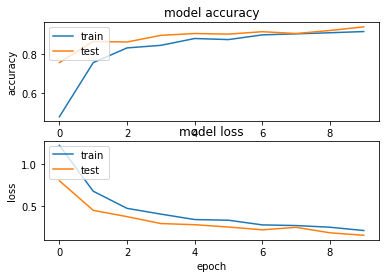

In [513]:
plt.figure(1)
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show() 

In [517]:
# Evaluation du modèle
(eval_loss, eval_accuracy) = model.evaluate(test_generator, steps=STEP_SIZE_TEST)
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss))

13/13 [==============================] - 25s 2s/step - loss: 1.9386 - accuracy: 0.6975
[INFO] accuracy: 69.75%
[INFO] Loss: 1.9385697841644287


In [515]:
# Affichage des classes du jeu d'entrainement
train_generator.class_indices

{'drink': 0, 'food': 1, 'inside': 2, 'menu': 3, 'outside': 4}

In [516]:
# Génération des prédictions
test_generator.reset()
pred = model.predict(test_generator)

13/13 [==============================] - 25s 2s/step


In [556]:
model_savepath = 'results/transfer_classifier_generator.h5'
# Sauvegarde du réseau après entrainement
model.save(model_savepath)   

## 5.3. Méthode 2

In [142]:
input_shape = (224,224,3)
vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=input_shape, classes=5)
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [143]:
for layer in vgg16.layers: 
    layer.trainable = False
    print('Layer ' + layer.name + ' frozen.')

Layer input_2 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer block4_conv1 frozen.
Layer block4_conv2 frozen.
Layer block4_conv3 frozen.
Layer block4_pool frozen.
Layer block5_conv1 frozen.
Layer block5_conv2 frozen.
Layer block5_conv3 frozen.
Layer block5_pool frozen.


In [144]:
last = vgg16.layers[-1].output
x = Flatten()(last)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dropout(0.3)(x)
x = Dense(5, activation='softmax', name='predictions')(x)

# Définir le nouveau modèle
model = Model(vgg16.input, x)

In [145]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [146]:
# Entraîner sur les données d'entraînement (X_train, y_train)
model_info = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10


C:\Users\solmy\anaconda3\envs\MachineLearning\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


40/40 [==============================] - 424s 11s/step - loss: 10.5250 - accuracy: 0.7508 - val_loss: 1.5884 - val_accuracy: 0.8375
Epoch 2/10
40/40 [==============================] - 423s 11s/step - loss: 0.7528 - accuracy: 0.9070 - val_loss: 0.9056 - val_accuracy: 0.8469
Epoch 3/10
40/40 [==============================] - 429s 11s/step - loss: 0.3395 - accuracy: 0.9398 - val_loss: 0.8594 - val_accuracy: 0.8813
Epoch 4/10
40/40 [==============================] - 421s 11s/step - loss: 0.3885 - accuracy: 0.9445 - val_loss: 0.8696 - val_accuracy: 0.8781
Epoch 5/10
40/40 [==============================] - 446s 11s/step - loss: 0.2928 - accuracy: 0.9547 - val_loss: 0.7221 - val_accuracy: 0.8562
Epoch 6/10
40/40 [==============================] - 437s 11s/step - loss: 0.2165 - accuracy: 0.9625 - val_loss: 0.7639 - val_accuracy: 0.8500
Epoch 7/10
40/40 [==============================] - 438s 11s/step - loss: 0.1139 - accuracy: 0.9766 - val_loss: 0.8873 - val_accuracy: 0.8750
Epoch 8/10
40/40

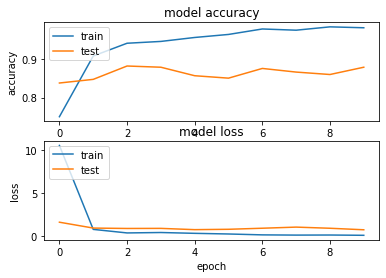

In [147]:
plt.figure(1)
plt.subplot(211)
plt.plot(model_info.history['accuracy'])
plt.plot(model_info.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(212)
plt.plot(model_info.history['loss'])
plt.plot(model_info.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show() 

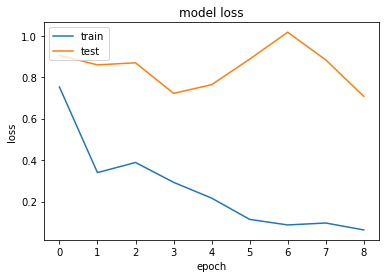

In [148]:
plt.plot(model_info.history['loss'][1:])
plt.plot(model_info.history['val_loss'][1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show() 

## Evaluation

In [150]:
# Evaluation du modèle
(eval_loss, eval_accuracy) = model.evaluate(X_test, y_test)
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss))

13/13 [==============================] - 28s 2s/step - loss: 1.0102 - accuracy: 0.8950
[INFO] accuracy: 89.50%
[INFO] Loss: 1.010168194770813


In [156]:
y_pred_labels = model.predict(X_test)

13/13 [==============================] - 25s 2s/step


In [172]:
y_pred = [np.argmax(y) for y in y_pred_labels]

In [173]:
y_true = [np.argmax(y) for y in y_test]

<AxesSubplot:>

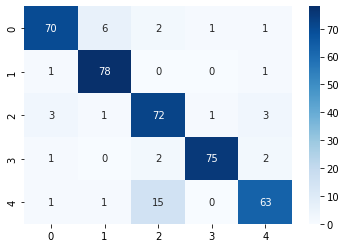

In [177]:
transfer_classifier_cm = metrics.confusion_matrix(y_true, y_pred)
plt.figure(figsize = (6,4))
sns.heatmap(transfer_classifier_cm, annot=True, cmap="Blues", fmt='g')

In [178]:
with open("data/X_test", "wb") as fp:
    pickle.dump(X_test, fp)

In [179]:
with open("data/y_test", "wb") as fp:
    pickle.dump(y_test, fp)

In [180]:
model_savepath = 'results/transfer_classifier.h5'
# Sauvegarde du réseau après entrainement
model.save(model_savepath)  

In [ ]:
index=[label for label in label_encoder.classes_